In [1]:
# Set GPU runtime first: Runtime > Change Runtime Type > GPU

# Check GPU
!nvidia-smi

Sat Jul  5 18:54:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   42C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Install specific compatible versions
!pip install gymnasium==0.29.1
!pip install ale-py==0.9.0
!pip install stable-baselines3==2.3.2
!pip install autorom[accept-rom-license]==0.6.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: gymnasium
    Found existing installation: gymnasium 1.2.0
    Uninstalling gymnasium-1.2.0:
      Successfully uninstalled gymnasium-1.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.1 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.8 MB/s eta 0:00:00
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.1
    Uninstalling ale-py-0.11.1:
      Successfully uninstalled ale-py-0.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.9.0 which 

In [3]:
# Install ROMs with proper acceptance
!AutoROM --accept-license --install-dir /usr/local/lib/python3.11/dist-packages/ale_py/roms

AutoROM will download the Atari 2600 ROMs.
They will be installed to:
	/usr/local/lib/python3.11/dist-packages/ale_py/roms

Existing ROMs will be overwritten.


In [6]:
import os
import random
import time
from dataclasses import dataclass
from typing import Optional

import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv,
    EpisodicLifeEnv,
    FireResetEnv,
    MaxAndSkipEnv,
    NoopResetEnv,
)
from stable_baselines3.common.buffers import ReplayBuffer
from torch.utils.tensorboard import SummaryWriter


@dataclass
class Args:
    """Hyperparameters for Custom Asteroids DQN"""
    exp_name: str = "custom_asteroids_dqn"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True

    # Environment - use the working Asteroids environment!
    env_id: str = "AsteroidsNoFrameskip-v4"  # Use NoFrameskip version for training

    # Training parameters
    total_timesteps: int = 1000000  # 1M timesteps (~90 minutes)
    learning_rate: float = 1e-4
    buffer_size: int = 100000
    gamma: float = 0.99
    target_network_frequency: int = 1000
    batch_size: int = 32
    start_e: float = 1.0
    end_e: float = 0.01
    exploration_fraction: float = 0.10
    learning_starts: int = 100000
    train_frequency: int = 4


class CustomQNetwork(nn.Module):
    """Custom CNN for Asteroids - you can modify this architecture!"""

    def __init__(self, env, hidden_size=512):
        super().__init__()
        self.env = env

        # CNN Feature Extractor - CUSTOMIZE THIS!
        self.network = nn.Sequential(
            # First conv layer: detect basic shapes
            nn.Conv2d(4, 32, 8, stride=4),
            nn.ReLU(),

            # Second conv layer: detect movement patterns
            nn.Conv2d(32, 64, 4, stride=2),
            nn.ReLU(),

            # Third conv layer: complex spatial relationships
            nn.Conv2d(64, 64, 3, stride=1),
            nn.ReLU(),

            nn.Flatten(),
        )

        # Calculate conv output size
        with torch.no_grad():
            sample_input = torch.zeros(1, 4, 84, 84)
            conv_output_size = self.network(sample_input).shape[1]

        # Value head - CUSTOMIZE THIS!
        self.value_head = nn.Sequential(
            nn.Linear(conv_output_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, env.single_action_space.n)
        )

    def forward(self, x):
        features = self.network(x / 255.0)  # Normalize pixels
        return self.value_head(features)


def make_env(env_id, seed, idx, capture_video, run_name):
    """Create Asteroids environment with proper wrappers"""
    def thunk():
        if capture_video and idx == 0:
            env = gym.make(env_id, render_mode="rgb_array")
            env = gym.wrappers.RecordVideo(env, f"videos/{run_name}")
        else:
            env = gym.make(env_id)

        print(f"✅ Successfully created environment: {env_id}")

        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = ClipRewardEnv(env)
        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)

        env.action_space.seed(seed)
        return env
    return thunk


def linear_schedule(start_e: float, end_e: float, duration: int, t: int):
    """Linear decay for exploration"""
    slope = (end_e - start_e) / duration
    return max(slope * t + start_e, end_e)


def train_asteroids_dqn():
    """Main training function"""
    args = Args()

    # Setup
    run_name = f"{args.env_id}__{args.exp_name}__{args.seed}__{int(time.time())}"
    writer = SummaryWriter(f"runs/{run_name}")

    # Seeding
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = args.torch_deterministic

    device = torch.device("cuda" if torch.cuda.is_available() and args.cuda else "cpu")

    # Environment
    envs = gym.vector.SyncVectorEnv([
        make_env(args.env_id, args.seed, 0, True, run_name)
    ])

    # Networks
    q_network = CustomQNetwork(envs, hidden_size=512).to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=args.learning_rate)
    target_network = CustomQNetwork(envs, hidden_size=512).to(device)
    target_network.load_state_dict(q_network.state_dict())

    # Experience Replay
    rb = ReplayBuffer(
        args.buffer_size,
        envs.single_observation_space,
        envs.single_action_space,
        device,
        handle_timeout_termination=False,
    )

    # Training Loop
    obs, _ = envs.reset(seed=args.seed)
    episode_rewards = []
    episode_lengths = []

    for global_step in range(args.total_timesteps):
        # Exploration rate
        epsilon = linear_schedule(
            args.start_e, args.end_e,
            args.exploration_fraction * args.total_timesteps,
            global_step
        )

        # Action selection
        if random.random() < epsilon:
            actions = np.array([envs.single_action_space.sample()])
        else:
            q_values = q_network(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        # Environment step
        next_obs, rewards, terminations, truncations, infos = envs.step(actions)

        # Track metrics
        if "final_info" in infos:
            for info in infos["final_info"]:
                if info and "episode" in info:
                    episode_rewards.append(info["episode"]["r"])
                    episode_lengths.append(info["episode"]["l"])
                    writer.add_scalar("charts/episodic_return", info["episode"]["r"], global_step)
                    writer.add_scalar("charts/episodic_length", info["episode"]["l"], global_step)
                    print(f"Step {global_step}, Episode reward: {info['episode']['r']}")

        # Store experience
        real_next_obs = next_obs.copy()
        for idx, d in enumerate(terminations):
            if d:
                real_next_obs[idx] = infos["final_observation"][idx]

        rb.add(obs, real_next_obs, actions, rewards, terminations, infos)
        obs = next_obs

        # Training
        if global_step > args.learning_starts:
            if global_step % args.train_frequency == 0:
                data = rb.sample(args.batch_size)

                with torch.no_grad():
                    target_max, _ = target_network(data.next_observations).max(dim=1)
                    td_target = data.rewards.flatten() + args.gamma * target_max * (1 - data.dones.flatten())

                old_val = q_network(data.observations).gather(1, data.actions).squeeze()
                loss = F.mse_loss(td_target, old_val)

                if global_step % 1000 == 0:
                    writer.add_scalar("losses/td_loss", loss, global_step)
                    writer.add_scalar("losses/q_values", old_val.mean().item(), global_step)
                    writer.add_scalar("charts/SPS", int(global_step / (time.time() - start_time)), global_step)

                # Optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Update target network
        if global_step % args.target_network_frequency == 0:
            target_network.load_state_dict(q_network.state_dict())

    # Save model
    model_path = f"models/{run_name}.pt"
    os.makedirs("models", exist_ok=True)
    torch.save(q_network.state_dict(), model_path)

    envs.close()
    writer.close()

    return q_network, episode_rewards, model_path


def evaluate_model(model_path, num_episodes=10):
    """Evaluate trained model on Asteroids"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Create environment
    env = gym.vector.SyncVectorEnv([make_env("AsteroidsNoFrameskip-v4", 42, 0, False, "eval")])
    q_network = CustomQNetwork(env).to(device)
    q_network.load_state_dict(torch.load(model_path))
    q_network.eval()

    print(f"✅ Evaluating on: AsteroidsNoFrameskip-v4")

    # Evaluate
    obs, _ = env.reset()
    episode_rewards = []
    episode_lengths = []
    current_reward = 0
    current_length = 0

    for step in range(50000):  # Max steps for evaluation
        with torch.no_grad():
            q_values = q_network(torch.Tensor(obs).to(device))
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

        obs, rewards, terminations, truncations, infos = env.step(actions)
        current_reward += rewards[0]
        current_length += 1

        if terminations[0] or truncations[0]:
            episode_rewards.append(current_reward)
            episode_lengths.append(current_length)
            print(f"Episode {len(episode_rewards)}: {current_reward} points, {current_length} steps")

            current_reward = 0
            current_length = 0
            obs, _ = env.reset()

            if len(episode_rewards) >= num_episodes:
                break

    env.close()

    # Results
    avg_reward = np.mean(episode_rewards)
    avg_length = np.mean(episode_lengths)

    print(f"\n📊 Evaluation Results:")
    print(f"Average Score: {avg_reward:.1f}")
    print(f"Average Length: {avg_length:.0f}")
    print(f"Best Score: {max(episode_rewards)}")
    print(f"Episodes: {len(episode_rewards)}")

    return episode_rewards, episode_lengths

"""
if __name__ == "__main__":
    start_time = time.time()
    print("🚀 Starting Custom Asteroids DQN Training...")

    # Train the model
    model, rewards, model_path = train_asteroids_dqn()

    print(f"✅ Training completed! Model saved to: {model_path}")
    print(f"Training time: {(time.time() - start_time)/60:.1f} minutes")

    # Evaluate the model
    print("\n🎯 Evaluating trained model...")
    eval_rewards, eval_lengths = evaluate_model(model_path)
"""


'\nif __name__ == "__main__":\n    start_time = time.time()\n    print("🚀 Starting Custom Asteroids DQN Training...")\n    \n    # Train the model\n    model, rewards, model_path = train_asteroids_dqn()\n    \n    print(f"✅ Training completed! Model saved to: {model_path}")\n    print(f"Training time: {(time.time() - start_time)/60:.1f} minutes")\n    \n    # Evaluate the model\n    print("\n🎯 Evaluating trained model...")\n    eval_rewards, eval_lengths = evaluate_model(model_path)\n'

In [ ]:
print("🚀 STARTING TRAINING WITH YOUR HIGH-MEMORY SETTINGS")
print("=" * 60)

# Display your settings
args_test = Args()
print("📋 Training Configuration:")
print(f"   Buffer Size: {args_test.buffer_size:,} experiences")
print(f"   Learning Starts: {args_test.learning_starts:,} steps")
print(f"   Total Steps: {args_test.total_timesteps:,}")
print(f"   Learning Rate: {args_test.learning_rate}")
print(f"   Batch Size: {args_test.batch_size}")
print(f"   Expected Time: ~4-5 hours")
print(f"   Target Performance: 300-500+ points")

print("\n🎯 Starting training now...")
start_time = time.time()

# Just run your training function
model, episode_rewards, model_path = train_asteroids_dqn()

# When done, show results
training_time = (time.time() - start_time) / 60
print(f"\n✅ TRAINING COMPLETED!")
print(f"⏱️  Training Time: {training_time:.1f} minutes")
print(f"📁 Model Saved: {model_path}")

# Quick evaluation
print("\n🎯 Quick Performance Check:")
eval_rewards, eval_lengths = evaluate_model(model_path, num_episodes=10)
avg_score = np.mean(eval_rewards)
print(f"Average Score: {avg_score:.1f} points")
print(f"Improvement vs Original (152.5): {avg_score - 152.5:+.1f} points")

if avg_score > 300:
    print("🔥 EXCELLENT! High-memory training worked!")
elif avg_score > 200:
    print("✅ GOOD! Significant improvement achieved!")
else:
    print("📈 Some improvement, may need more analysis")

🚀 STARTING TRAINING WITH YOUR HIGH-MEMORY SETTINGS
📋 Training Configuration:
   Buffer Size: 400,000 experiences
   Learning Starts: 400,000 steps
   Total Steps: 2,000,000
   Learning Rate: 5e-05
   Batch Size: 64
   Expected Time: ~4-5 hours
   Target Performance: 300-500+ points

🎯 Starting training now...
✅ Successfully created environment: AsteroidsNoFrameskip-v4


/tmp/ipython-input-6-2963012434.py:200: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  real_next_obs[idx] = infos["final_observation"][idx]


Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-0.mp4
Step 538, Episode reward: [480.]
Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-1.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-1.mp4
Step 1318, Episode reward: [460.]
Step 3203, Episode reward: [1340.]
Step 5422, Episode reward: [2000.]
Step 6725, Episode reward: [1080.]
Step 8510, Episode reward: [1300.]
Step 10160, Episode reward: [1300.]
Step 10956, Episode reward: [830.]
Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-8.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-8.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-8.mp4
Step 12093, Episode reward: [730.]
Step 12437, Episode reward: [160.]
Step 14134, Episode reward: [1080.]
Step 14447, Episode reward: [360.]
Step 14967, Episode reward: [330.]
Step 16256, Episode reward: [930.]
Step 16914, Episode reward: [730.]
Step 17477, Episode reward: [280.]
Step 18297, Episode reward: [430.]
Step 18771, Episode reward: [310.]
Step 19161, Episode reward: [210.]
Step 19686, Episode reward: [480.]
Step 20034, Episode reward: [580.]
Step 22163, Episode reward: [1440.]
Step 22851, Episode reward: [430.]
Step 23785, Episode reward: [1280.]
Step 24333, Episode reward: [230.]
Step 25071, Episode reward: [630.]
Step 25293, Episode reward: [140.]
Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-27.mp4.
Moviepy - Writing video /content/videos/Asteroid

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-27.mp4
Step 26144, Episode reward: [880.]
Step 28067, Episode reward: [1300.]
Step 29717, Episode reward: [1280.]
Step 31179, Episode reward: [1440.]
Step 32021, Episode reward: [530.]
Step 33107, Episode reward: [630.]
Step 33772, Episode reward: [680.]
Step 34536, Episode reward: [730.]
Step 35093, Episode reward: [730.]
Step 35477, Episode reward: [330.]
Step 35864, Episode reward: [380.]
Step 36794, Episode reward: [680.]
Step 37391, Episode reward: [630.]
Step 40269, Episode reward: [1300.]
Step 42204, Episode reward: [1480.]
Step 42720, Episode reward: [430.]
Step 43331, Episode reward: [180.]
Step 44278, Episode reward: [880.]
Step 46712, Episode reward: [1530.]
Step 47468, Episode reward: [730.]
Step 48027, Episode reward: [480.]
Step 48253, Episode reward: [240.]
Step 49081, Episode reward: [580.]
Step 49852, Episode reward: [580.]
Step 

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-64.mp4
Step 65355, Episode reward: [1300.]
Step 66323, Episode reward: [530.]
Step 66783, Episode reward: [430.]
Step 67635, Episode reward: [630.]
Step 68119, Episode reward: [480.]
Step 69020, Episode reward: [930.]
Step 69775, Episode reward: [430.]
Step 70833, Episode reward: [680.]
Step 73339, Episode reward: [1760.]
Step 74230, Episode reward: [610.]
Step 75171, Episode reward: [680.]
Step 75450, Episode reward: [160.]
Step 75791, Episode reward: [280.]
Step 76601, Episode reward: [280.]
Step 78179, Episode reward: [1300.]
Step 78930, Episode reward: [580.]
Step 79475, Episode reward: [610.]
Step 80011, Episode reward: [280.]
Step 81112, Episode reward: [730.]
Step 82256, Episode reward: [880.]
Step 83060, Episode reward: [680.]
Step 85916, Episode reward: [2300.]
Step 87372, Episode reward: [830.]
Step 87948, Episode reward: [380.]
Step 88

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-125.mp4
Step 131350, Episode reward: [830.]
Step 131886, Episode reward: [210.]
Step 132400, Episode reward: [280.]
Step 132874, Episode reward: [280.]
Step 133731, Episode reward: [310.]
Step 134509, Episode reward: [630.]
Step 135922, Episode reward: [880.]
Step 136747, Episode reward: [330.]
Step 137271, Episode reward: [80.]
Step 137742, Episode reward: [230.]
Step 140212, Episode reward: [1300.]
Step 140968, Episode reward: [430.]
Step 141493, Episode reward: [230.]
Step 142602, Episode reward: [630.]
Step 143151, Episode reward: [260.]
Step 143580, Episode reward: [380.]
Step 144369, Episode reward: [380.]
Step 145364, Episode reward: [680.]
Step 146388, Episode reward: [530.]
Step 147475, Episode reward: [530.]
Step 148106, Episode reward: [430.]
Step 148600, Episode reward: [310.]
Step 149271, Episode reward: [380.]
Step 150257, Episode r

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-216.mp4
Step 207990, Episode reward: [180.]
Step 208438, Episode reward: [160.]
Step 209040, Episode reward: [310.]
Step 209768, Episode reward: [230.]
Step 210547, Episode reward: [360.]
Step 211064, Episode reward: [260.]
Step 211813, Episode reward: [310.]
Step 212598, Episode reward: [230.]
Step 213444, Episode reward: [230.]
Step 214763, Episode reward: [530.]
Step 215299, Episode reward: [110.]
Step 216383, Episode reward: [430.]
Step 217025, Episode reward: [230.]
Step 217350, Episode reward: [230.]
Step 218219, Episode reward: [180.]
Step 219584, Episode reward: [280.]
Step 220722, Episode reward: [430.]
Step 221564, Episode reward: [280.]
Step 222618, Episode reward: [280.]
Step 223813, Episode reward: [510.]
Step 224412, Episode reward: [280.]
Step 225221, Episode reward: [430.]
Step 225996, Episode reward: [180.]
Step 227177, Episode r

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-343.mp4
Step 303759, Episode reward: [140.]
Step 304570, Episode reward: [160.]
Step 304838, Episode reward: [80.]
Step 305907, Episode reward: [80.]
Step 306495, Episode reward: [110.]
Step 307802, Episode reward: [110.]
Step 308348, Episode reward: [140.]
Step 309656, Episode reward: [110.]
Step 310204, Episode reward: [140.]
Step 310793, Episode reward: [110.]
Step 311275, Episode reward: [140.]
Step 311757, Episode reward: [140.]
Step 312241, Episode reward: [110.]
Step 312527, Episode reward: [80.]
Step 313629, Episode reward: [80.]
Step 314161, Episode reward: [80.]
Step 314694, Episode reward: [80.]
Step 315226, Episode reward: [80.]
Step 316620, Episode reward: [110.]
Step 316906, Episode reward: [80.]
Step 317751, Episode reward: [80.]
Step 318301, Episode reward: [110.]
Step 318834, Episode reward: [80.]
Step 319421, Episode reward: [11

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-512.mp4
Step 414916, Episode reward: [260.]
Step 415505, Episode reward: [390.]
Step 416092, Episode reward: [560.]
Step 416654, Episode reward: [310.]
Step 417058, Episode reward: [310.]
Step 417393, Episode reward: [180.]
Step 418028, Episode reward: [280.]
Step 418480, Episode reward: [180.]
Step 418881, Episode reward: [330.]
Step 419270, Episode reward: [130.]
Step 419781, Episode reward: [310.]
Step 420334, Episode reward: [180.]
Step 420857, Episode reward: [110.]
Step 421258, Episode reward: [210.]
Step 422029, Episode reward: [310.]
Step 422472, Episode reward: [330.]
Step 423194, Episode reward: [480.]
Step 423524, Episode reward: [80.]
Step 424280, Episode reward: [430.]
Step 424757, Episode reward: [380.]
Step 425250, Episode reward: [290.]
Step 426015, Episode reward: [380.]
Step 426606, Episode reward: [260.]
Step 427001, Episode re

Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__max_performance_asteroids_dqn__1__1751742504/rl-video-episode-729.mp4
Step 533025, Episode reward: [460.]
Step 534044, Episode reward: [610.]
Step 534855, Episode reward: [730.]
Step 535273, Episode reward: [230.]
Step 536173, Episode reward: [730.]
Step 536546, Episode reward: [180.]
Step 537048, Episode reward: [580.]
Step 537834, Episode reward: [480.]
Step 538626, Episode reward: [430.]
Step 539292, Episode reward: [380.]
Step 539841, Episode reward: [380.]
Step 540242, Episode reward: [330.]
Step 540800, Episode reward: [330.]
Step 541300, Episode reward: [330.]
Step 541788, Episode reward: [580.]
Step 542447, Episode reward: [780.]
Step 543252, Episode reward: [580.]
Step 544011, Episode reward: [430.]
Step 544727, Episode reward: [330.]
Step 545402, Episode reward: [630.]
Step 546130, Episode reward: [580.]
Step 547517, Episode reward: [880.]
Step 548187, Episode reward: [260.]
Step 548617, Episode r

In [4]:
# Test basic imports first
try:
    import gymnasium as gym
    print(f"✅ Gymnasium {gym.__version__} imported successfully")
except Exception as e:
    print(f"❌ Gymnasium import failed: {e}")

try:
    import ale_py
    print(f"✅ ALE-py {ale_py.__version__} imported successfully")
except Exception as e:
    print(f"❌ ALE-py import failed: {e}")

try:
    import stable_baselines3
    print(f"✅ Stable-Baselines3 {stable_baselines3.__version__} imported successfully")
except Exception as e:
    print(f"❌ Stable-Baselines3 import failed: {e}")

✅ Gymnasium 0.29.1 imported successfully
✅ ALE-py 0.9.0 imported successfully
✅ Stable-Baselines3 2.3.2 imported successfully


In [5]:
import gymnasium as gym
import ale_py

print("🔍 Testing Asteroids with compatible versions...")

try:
    # Register ALE environments
    gym.register_envs(ale_py)
    print("✅ ALE environments registered")

    # Check available environments
    all_envs = list(gym.envs.registry.keys())
    asteroid_envs = [env for env in all_envs if 'asteroid' in env.lower()]
    print(f"Asteroid environments found: {asteroid_envs}")

    # Try to create Asteroids environment
    if asteroid_envs:
        env_name = asteroid_envs[0]
        env = gym.make(env_name)
        print(f"✅ Successfully created: {env_name}")

        obs, info = env.reset()
        print(f"✅ Environment reset successful")
        print(f"  Observation shape: {obs.shape}")
        print(f"  Action space: {env.action_space}")

        # Test one step
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        print(f"✅ Environment step successful")

        env.close()
        working_env = env_name

    else:
        # Try direct ALE approach
        ale = ale_py.ALEInterface()
        available_roms = ale.getAvailableRoms()
        print(f"Available ROMs: {available_roms}")

        if 'asteroids' in available_roms:
            ale.loadROM('asteroids')
            print("✅ Direct ALE Asteroids loading successful")
            working_env = 'direct_ale'
        else:
            working_env = None

except Exception as e:
    print(f"❌ Environment test failed: {e}")
    working_env = None

print(f"\n🎯 Working environment: {working_env}")

🔍 Testing Asteroids with compatible versions...
✅ ALE environments registered
Asteroid environments found: ['Asteroids-v0', 'AsteroidsDeterministic-v0', 'AsteroidsNoFrameskip-v0', 'Asteroids-v4', 'AsteroidsDeterministic-v4', 'AsteroidsNoFrameskip-v4', 'Asteroids-ram-v0', 'Asteroids-ramDeterministic-v0', 'Asteroids-ramNoFrameskip-v0', 'Asteroids-ram-v4', 'Asteroids-ramDeterministic-v4', 'Asteroids-ramNoFrameskip-v4', 'ALE/Asteroids-v5', 'ALE/Asteroids-ram-v5']
✅ Successfully created: Asteroids-v0
✅ Environment reset successful
  Observation shape: (210, 160, 3)
  Action space: Discrete(14)
✅ Environment step successful

🎯 Working environment: Asteroids-v0


/usr/local/lib/python3.11/dist-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment Asteroids-v0 is out of date. You should consider upgrading to version `v4`.
  logger.deprecation(


## DQN Code for Asteroids

In [11]:
@dataclass
class Args:
    """Fixed Args class with all required parameters"""
    exp_name: str = "max_performance_asteroids_dqn"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True

    env_id: str = "AsteroidsNoFrameskip-v4"

    # MAXIMUM PERFORMANCE SETTINGS
    total_timesteps: int = 2000000
    learning_rate: float = 5e-5
    buffer_size: int = 400000
    batch_size: int = 64
    target_network_frequency: int = 2000
    exploration_fraction: float = 0.15
    train_frequency: int = 2
    gamma: float = 0.99
    gradient_steps: int = 1
    learning_starts: int = 400000

    # FIXED: Include both parameter names for compatibility
    start_e: float = 1.0
    end_e: float = 0.005                    # 🔧 FIX: This was missing
    exploration_final_eps: float = 0.005    # Same value, different name

print("✅ Args class fixed with both parameter names")
print("   start_e: 1.0")
print("   end_e: 0.005")
print("   exploration_final_eps: 0.005")


✅ Args class fixed with both parameter names
   start_e: 1.0
   end_e: 0.005
   exploration_final_eps: 0.005


## Evaluation code

🎯 COMPREHENSIVE ASTEROIDS MODEL EVALUATION

1️⃣ EVALUATING WITHOUT REWARD CLIPPING (True Game Scores)
--------------------------------------------------
Episode  1:  160.0 points in  311 steps (1.5s)
Episode  2:   50.0 points in   45 steps (0.1s)
Episode  3:  120.0 points in  392 steps (0.8s)
Episode  4:   50.0 points in  117 steps (0.3s)
Episode  5:  190.0 points in  678 steps (1.4s)
Episode  6:   40.0 points in  409 steps (0.9s)
Episode  7:   50.0 points in   78 steps (0.2s)
Episode  8:   50.0 points in  201 steps (0.4s)
Episode  9:   40.0 points in   82 steps (0.2s)
Episode 10:  200.0 points in  198 steps (0.4s)
Episode 11:   20.0 points in  170 steps (0.4s)
Episode 12:  470.0 points in  441 steps (1.0s)
Episode 13:  110.0 points in  203 steps (0.4s)
Episode 14:  270.0 points in  175 steps (0.4s)
Episode 15:  300.0 points in  122 steps (0.3s)
Episode 16:  400.0 points in 1435 steps (3.4s)
Episode 17:   80.0 points in  189 steps (0.6s)
Episode 18:  100.0 points in   98 steps (0.3s)
E

/tmp/ipython-input-33-3595531283.py:288: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=labels)



📊 Plots saved to: asteroids_comprehensive_evaluation.png


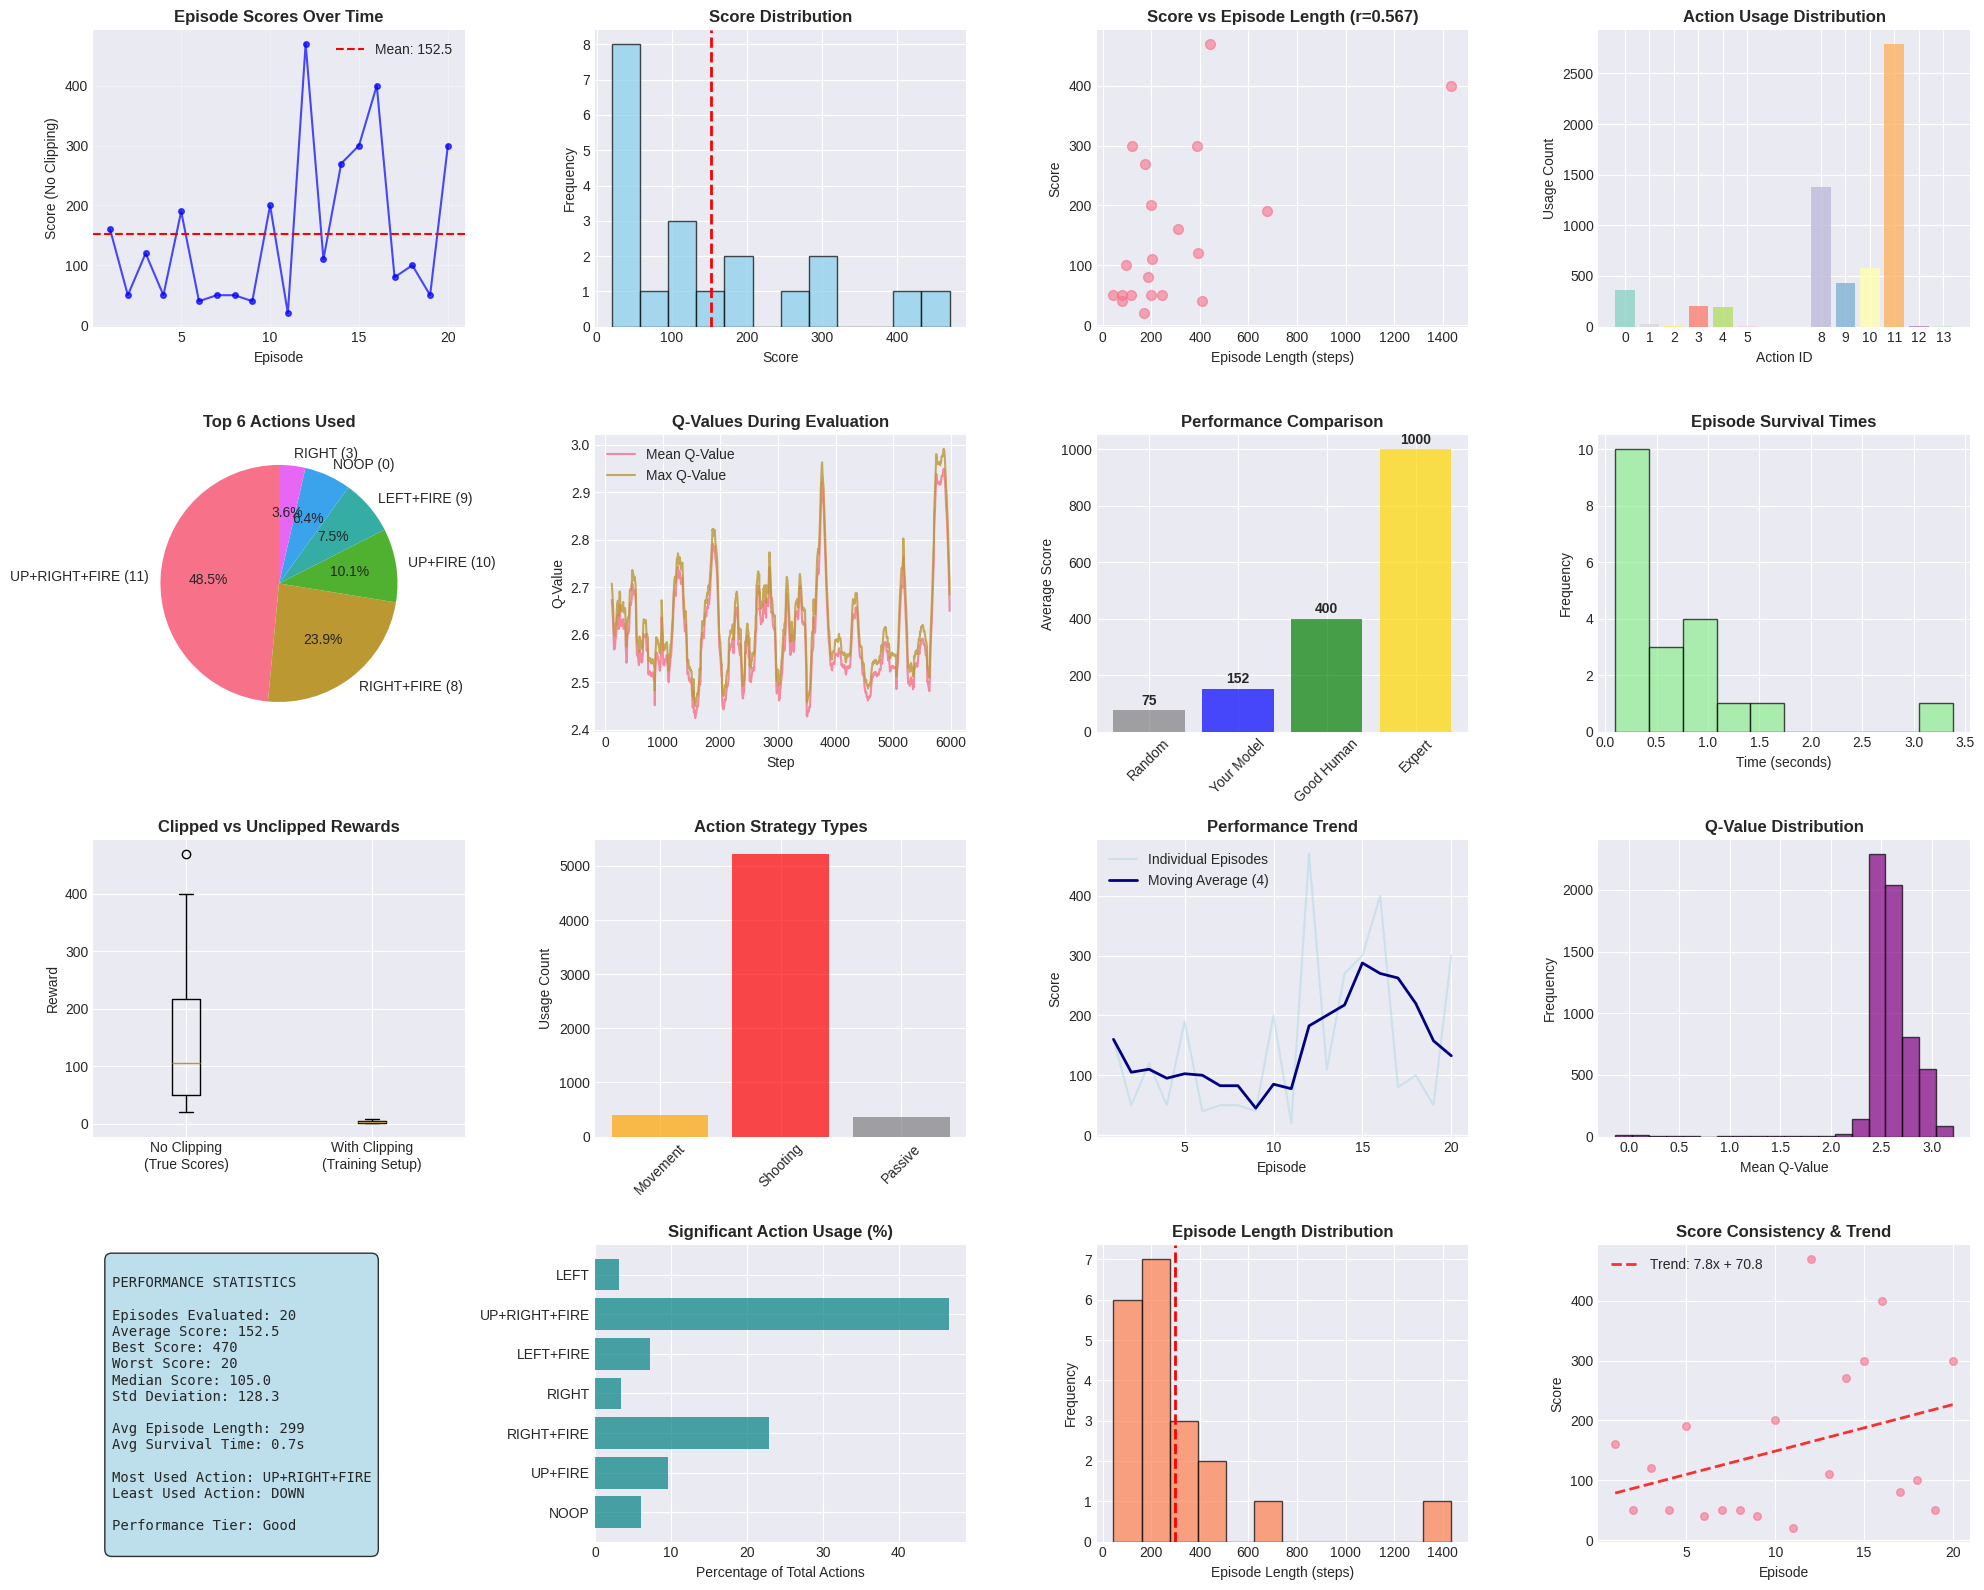


🏆 COMPREHENSIVE EVALUATION SUMMARY
Average Performance: 152.5 points
Performance Range: 20 - 470 points
Consistency (CV): 0.842

🎮 STRATEGY ANALYSIS:
Shooting actions: 87.2% of play
Movement actions: 6.7% of play
Most used action: UP+RIGHT+FIRE (2786 times)

✅ GOOD LEVEL
Performance vs Random (~75): 2.0x better
Performance vs Expert (1000): 15.2%


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
import gymnasium as gym
import ale_py
from collections import defaultdict
import time
from stable_baselines3.common.atari_wrappers import (
    ClipRewardEnv, EpisodicLifeEnv, FireResetEnv,
    MaxAndSkipEnv, NoopResetEnv
)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def comprehensive_asteroids_evaluation(model_path, device, num_episodes=25, include_clipped=True, save_plots=True):
    """
    Comprehensive evaluation of Asteroids DQN model with detailed analysis and plotting

    Args:
        model_path: Path to trained model
        device: torch device
        num_episodes: Number of episodes to evaluate
        include_clipped: Whether to also test with reward clipping
        save_plots: Whether to save plots to files

    Returns:
        Dictionary with evaluation results and statistics
    """

    print("🎯 COMPREHENSIVE ASTEROIDS MODEL EVALUATION")
    print("=" * 60)

    # Register ALE environments
    gym.register_envs(ale_py)

    # Action names for analysis
    action_names = ['NOOP', 'FIRE', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UP+RIGHT', 'UP+LEFT',
                    'RIGHT+FIRE', 'LEFT+FIRE', 'UP+FIRE', 'UP+RIGHT+FIRE', 'UP+LEFT+FIRE', 'DOWN+FIRE']

    def make_env_no_clip():
        """Environment without reward clipping (shows true game scores)"""
        env = gym.make("AsteroidsNoFrameskip-v4", render_mode="rgb_array")
        env = gym.wrappers.RecordEpisodeStatistics(env)
        env = NoopResetEnv(env, noop_max=30)
        env = MaxAndSkipEnv(env, skip=4)
        env = EpisodicLifeEnv(env)

        if "FIRE" in env.unwrapped.get_action_meanings():
            env = FireResetEnv(env)

        env = gym.wrappers.ResizeObservation(env, (84, 84))
        env = gym.wrappers.GrayScaleObservation(env)
        env = gym.wrappers.FrameStack(env, 4)
        return env

    def make_env_with_clip():
        """Environment with reward clipping (training setup)"""
        env = make_env_no_clip()
        env = ClipRewardEnv(env)  # Add clipping
        return env

    # Load model
    dummy_env = gym.vector.SyncVectorEnv([make_env_no_clip])
    q_network = CustomQNetwork(dummy_env).to(device)
    q_network.load_state_dict(torch.load(model_path))
    q_network.eval()
    dummy_env.close()

    results = {}

    # Evaluation 1: Without reward clipping (true game performance)
    print(f"\n1️⃣ EVALUATING WITHOUT REWARD CLIPPING (True Game Scores)")
    print("-" * 50)

    env = gym.vector.SyncVectorEnv([make_env_no_clip])

    episode_rewards = []
    episode_lengths = []
    action_counts = defaultdict(int)
    q_value_history = []
    reward_timeline = []
    survival_times = []
    step_rewards = []

    obs, _ = env.reset()
    current_reward = 0
    current_length = 0
    episode_start_time = time.time()

    for step in range(200000):  # Max steps
        with torch.no_grad():
            obs_array = np.array(obs) if hasattr(obs, '__array__') else obs
            obs_tensor = torch.FloatTensor(obs_array).to(device)
            q_values = q_network(obs_tensor)
            actions = torch.argmax(q_values, dim=1).cpu().numpy()

            # Record Q-values
            q_vals = q_values.cpu().numpy().flatten()
            q_value_history.append({
                'step': step,
                'mean_q': q_vals.mean(),
                'max_q': q_vals.max(),
                'action': actions[0],
                'q_for_action': q_vals[actions[0]]
            })

        action_counts[actions[0]] += 1

        obs, rewards, terminations, truncations, infos = env.step(actions)
        current_reward += rewards[0]
        current_length += 1
        step_rewards.append(rewards[0])

        if terminations[0] or truncations[0]:
            episode_time = time.time() - episode_start_time
            episode_rewards.append(current_reward)
            episode_lengths.append(current_length)
            survival_times.append(episode_time)
            reward_timeline.extend(step_rewards)

            print(f"Episode {len(episode_rewards):2d}: {current_reward:6.1f} points in {current_length:4d} steps ({episode_time:.1f}s)")

            current_reward = 0
            current_length = 0
            step_rewards = []
            episode_start_time = time.time()
            obs, _ = env.reset()

            if len(episode_rewards) >= num_episodes:
                break

    env.close()

    results['no_clip'] = {
        'episode_rewards': episode_rewards,
        'episode_lengths': episode_lengths,
        'action_counts': dict(action_counts),
        'q_value_history': q_value_history,
        'survival_times': survival_times,
        'reward_timeline': reward_timeline
    }

    # Evaluation 2: With reward clipping (training setup)
    if include_clipped:
        print(f"\n2️⃣ EVALUATING WITH REWARD CLIPPING (Training Setup)")
        print("-" * 50)

        env = gym.vector.SyncVectorEnv([make_env_with_clip])

        clipped_rewards = []
        clipped_lengths = []

        obs, _ = env.reset()
        current_reward = 0
        current_length = 0

        for step in range(100000):
            with torch.no_grad():
                obs_array = np.array(obs) if hasattr(obs, '__array__') else obs
                obs_tensor = torch.FloatTensor(obs_array).to(device)
                q_values = q_network(obs_tensor)
                actions = torch.argmax(q_values, dim=1).cpu().numpy()

            obs, rewards, terminations, truncations, infos = env.step(actions)
            current_reward += rewards[0]
            current_length += 1

            if terminations[0] or truncations[0]:
                clipped_rewards.append(current_reward)
                clipped_lengths.append(current_length)

                print(f"Episode {len(clipped_rewards):2d}: {current_reward:4.1f} clipped reward in {current_length:4d} steps")

                current_reward = 0
                current_length = 0
                obs, _ = env.reset()

                if len(clipped_rewards) >= min(10, num_episodes):
                    break

        env.close()

        results['clipped'] = {
            'episode_rewards': clipped_rewards,
            'episode_lengths': clipped_lengths
        }

    # Generate comprehensive plots
    fig = plt.figure(figsize=(20, 16))

    # 1. Episode Performance Over Time
    plt.subplot(4, 4, 1)
    episodes = range(1, len(episode_rewards) + 1)
    plt.plot(episodes, episode_rewards, 'b-o', markersize=4, alpha=0.7)
    plt.axhline(np.mean(episode_rewards), color='red', linestyle='--',
                label=f'Mean: {np.mean(episode_rewards):.1f}')
    plt.title('Episode Scores Over Time', fontweight='bold', fontsize=12)
    plt.xlabel('Episode')
    plt.ylabel('Score (No Clipping)')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Score Distribution
    plt.subplot(4, 4, 2)
    plt.hist(episode_rewards, bins=12, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(episode_rewards), color='red', linestyle='--', linewidth=2)
    plt.title('Score Distribution', fontweight='bold', fontsize=12)
    plt.xlabel('Score')
    plt.ylabel('Frequency')

    # 3. Episode Length vs Score
    plt.subplot(4, 4, 3)
    plt.scatter(episode_lengths, episode_rewards, alpha=0.6, s=50)
    correlation = np.corrcoef(episode_lengths, episode_rewards)[0, 1]
    plt.title(f'Score vs Episode Length (r={correlation:.3f})', fontweight='bold', fontsize=12)
    plt.xlabel('Episode Length (steps)')
    plt.ylabel('Score')

    # 4. Action Usage Distribution
    plt.subplot(4, 4, 4)
    actions = list(action_counts.keys())
    counts = [action_counts[a] for a in actions]
    colors = plt.cm.Set3(np.linspace(0, 1, len(actions)))
    bars = plt.bar(actions, counts, color=colors, alpha=0.8)
    plt.title('Action Usage Distribution', fontweight='bold', fontsize=12)
    plt.xlabel('Action ID')
    plt.ylabel('Usage Count')
    plt.xticks(actions, [str(a) for a in actions])

    # 5. Action Usage Pie Chart (Top 6)
    plt.subplot(4, 4, 5)
    sorted_actions = sorted(action_counts.items(), key=lambda x: x[1], reverse=True)[:6]
    labels = [f"{action_names[a]} ({a})" for a, _ in sorted_actions]
    sizes = [count for _, count in sorted_actions]
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Top 6 Actions Used', fontweight='bold', fontsize=12)

    # 6. Q-Value Statistics Over Time
    plt.subplot(4, 4, 6)
    if q_value_history:
        q_df = pd.DataFrame(q_value_history)
        window = max(1, len(q_df) // 50)
        mean_q_smooth = q_df['mean_q'].rolling(window=window).mean()
        max_q_smooth = q_df['max_q'].rolling(window=window).mean()

        plt.plot(mean_q_smooth.index, mean_q_smooth, label='Mean Q-Value', alpha=0.8)
        plt.plot(max_q_smooth.index, max_q_smooth, label='Max Q-Value', alpha=0.8)
        plt.title('Q-Values During Evaluation', fontweight='bold', fontsize=12)
        plt.xlabel('Step')
        plt.ylabel('Q-Value')
        plt.legend()

    # 7. Performance Comparison Bar Chart
    plt.subplot(4, 4, 7)
    comparison_data = {
        'Random': 75,  # Typical random performance
        'Your Model': np.mean(episode_rewards),
        'Good Human': 400,
        'Expert': 1000
    }
    bars = plt.bar(comparison_data.keys(), comparison_data.values(),
                   color=['gray', 'blue', 'green', 'gold'], alpha=0.7)
    plt.title('Performance Comparison', fontweight='bold', fontsize=12)
    plt.ylabel('Average Score')
    plt.xticks(rotation=45)

    # Add value labels
    for bar, value in zip(bars, comparison_data.values()):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                f'{value:.0f}', ha='center', va='bottom', fontweight='bold')

    # 8. Survival Time Analysis
    plt.subplot(4, 4, 8)
    plt.hist(survival_times, bins=10, alpha=0.7, color='lightgreen', edgecolor='black')
    plt.title('Episode Survival Times', fontweight='bold', fontsize=12)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Frequency')

    # 9. Clipped vs Unclipped Comparison (if available)
    plt.subplot(4, 4, 9)
    if include_clipped and 'clipped' in results:
        data_to_plot = [episode_rewards, results['clipped']['episode_rewards']]
        labels = ['No Clipping\n(True Scores)', 'With Clipping\n(Training Setup)']
        plt.boxplot(data_to_plot, labels=labels)
        plt.title('Clipped vs Unclipped Rewards', fontweight='bold', fontsize=12)
        plt.ylabel('Reward')
    else:
        plt.boxplot([episode_rewards])
        plt.title('Score Distribution (Box Plot)', fontweight='bold', fontsize=12)
        plt.ylabel('Score')

    # 10. Action Strategy Heatmap
    plt.subplot(4, 4, 10)
    # Group actions by type
    action_types = {
        'Movement': [2, 3, 4, 6, 7],  # UP, RIGHT, LEFT, UP+RIGHT, UP+LEFT
        'Shooting': [1, 8, 9, 10, 11, 12, 13],  # FIRE combinations
        'Passive': [0, 5]  # NOOP, DOWN (hyperspace)
    }

    type_counts = {}
    for action_type, action_list in action_types.items():
        type_counts[action_type] = sum(action_counts.get(a, 0) for a in action_list)

    plt.bar(type_counts.keys(), type_counts.values(),
            color=['orange', 'red', 'gray'], alpha=0.7)
    plt.title('Action Strategy Types', fontweight='bold', fontsize=12)
    plt.ylabel('Usage Count')
    plt.xticks(rotation=45)

    # 11. Moving Average Performance
    plt.subplot(4, 4, 11)
    window = max(3, len(episode_rewards) // 5)
    moving_avg = pd.Series(episode_rewards).rolling(window=window, min_periods=1).mean()
    plt.plot(episodes, episode_rewards, 'lightblue', alpha=0.5, label='Individual Episodes')
    plt.plot(episodes, moving_avg, 'navy', linewidth=2, label=f'Moving Average ({window})')
    plt.title('Performance Trend', fontweight='bold', fontsize=12)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()

    # 12. Q-Value Distribution
    plt.subplot(4, 4, 12)
    if q_value_history:
        all_q_vals = [q['mean_q'] for q in q_value_history]
        plt.hist(all_q_vals, bins=20, alpha=0.7, color='purple', edgecolor='black')
        plt.title('Q-Value Distribution', fontweight='bold', fontsize=12)
        plt.xlabel('Mean Q-Value')
        plt.ylabel('Frequency')

    # 13. Performance Statistics Text
    plt.subplot(4, 4, 13)
    plt.axis('off')
    stats_text = f"""
PERFORMANCE STATISTICS

Episodes Evaluated: {len(episode_rewards)}
Average Score: {np.mean(episode_rewards):.1f}
Best Score: {max(episode_rewards):.0f}
Worst Score: {min(episode_rewards):.0f}
Median Score: {np.median(episode_rewards):.1f}
Std Deviation: {np.std(episode_rewards):.1f}

Avg Episode Length: {np.mean(episode_lengths):.0f}
Avg Survival Time: {np.mean(survival_times):.1f}s

Most Used Action: {action_names[max(action_counts, key=action_counts.get)]}
Least Used Action: {action_names[min(action_counts, key=action_counts.get)]}

Performance Tier: {'Expert' if np.mean(episode_rewards) > 800 else 'Advanced' if np.mean(episode_rewards) > 400 else 'Good' if np.mean(episode_rewards) > 150 else 'Basic'}
"""
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', fontfamily='monospace',
             bbox=dict(boxstyle="round,pad=0.5", facecolor="lightblue", alpha=0.8))

    # 14. Action Sequence Analysis
    plt.subplot(4, 4, 14)
    # Show action preferences as percentages
    total_actions = sum(action_counts.values())
    action_percentages = {a: (count/total_actions)*100 for a, count in action_counts.items()}

    # Filter to show only actions used > 1%
    significant_actions = {a: p for a, p in action_percentages.items() if p > 1.0}

    if significant_actions:
        actions_list = list(significant_actions.keys())
        percentages = list(significant_actions.values())
        action_labels = [action_names[a] for a in actions_list]

        plt.barh(action_labels, percentages, color='teal', alpha=0.7)
        plt.title('Significant Action Usage (%)', fontweight='bold', fontsize=12)
        plt.xlabel('Percentage of Total Actions')

    # 15. Episode Length Distribution
    plt.subplot(4, 4, 15)
    plt.hist(episode_lengths, bins=12, alpha=0.7, color='coral', edgecolor='black')
    plt.axvline(np.mean(episode_lengths), color='red', linestyle='--', linewidth=2)
    plt.title('Episode Length Distribution', fontweight='bold', fontsize=12)
    plt.xlabel('Episode Length (steps)')
    plt.ylabel('Frequency')

    # 16. Learning Consistency
    plt.subplot(4, 4, 16)
    # Plot score vs episode number with trend line
    z = np.polyfit(episodes, episode_rewards, 1)
    p = np.poly1d(z)
    plt.scatter(episodes, episode_rewards, alpha=0.6, s=30)
    plt.plot(episodes, p(episodes), "r--", alpha=0.8, linewidth=2,
             label=f'Trend: {z[0]:.1f}x + {z[1]:.1f}')
    plt.title('Score Consistency & Trend', fontweight='bold', fontsize=12)
    plt.xlabel('Episode')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()

    if save_plots:
        plt.savefig('asteroids_comprehensive_evaluation.png', dpi=300, bbox_inches='tight')
        print(f"\n📊 Plots saved to: asteroids_comprehensive_evaluation.png")

    plt.show()

    # Print comprehensive summary
    print(f"\n🏆 COMPREHENSIVE EVALUATION SUMMARY")
    print("=" * 60)

    avg_score = np.mean(episode_rewards)
    print(f"Average Performance: {avg_score:.1f} points")
    print(f"Performance Range: {min(episode_rewards):.0f} - {max(episode_rewards):.0f} points")
    print(f"Consistency (CV): {np.std(episode_rewards)/avg_score:.3f}")

    # Strategy analysis
    shooting_actions = [1, 8, 9, 10, 11, 12, 13]
    movement_actions = [2, 3, 4, 6, 7]

    total_actions = sum(action_counts.values())
    shooting_pct = sum(action_counts.get(a, 0) for a in shooting_actions) / total_actions * 100
    movement_pct = sum(action_counts.get(a, 0) for a in movement_actions) / total_actions * 100

    print(f"\n🎮 STRATEGY ANALYSIS:")
    print(f"Shooting actions: {shooting_pct:.1f}% of play")
    print(f"Movement actions: {movement_pct:.1f}% of play")
    print(f"Most used action: {action_names[max(action_counts, key=action_counts.get)]} ({max(action_counts.values())} times)")

    # Performance tier
    if avg_score > 800:
        tier = "🏆 EXPERT LEVEL"
    elif avg_score > 400:
        tier = "🔥 ADVANCED LEVEL"
    elif avg_score > 150:
        tier = "✅ GOOD LEVEL"
    elif avg_score > 75:
        tier = "👍 BASIC LEVEL"
    else:
        tier = "📈 LEARNING LEVEL"

    print(f"\n{tier}")
    print(f"Performance vs Random (~75): {avg_score/75:.1f}x better")
    print(f"Performance vs Expert (1000): {avg_score/1000:.1%}")

    return results

# Example usage function
def evaluate_your_model():
    """
    Example function to evaluate your trained model
    Modify the model_path to point to your trained model
    """
    # Update this path to your actual model
    model_path = "models/AsteroidsNoFrameskip-v4__custom_asteroids_dqn__1__1751735191.pt"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Run comprehensive evaluation
    results = comprehensive_asteroids_evaluation(
        model_path=model_path,
        device=device,
        num_episodes=20,
        include_clipped=True,
        save_plots=True
    )

    return results

# Run evaluation if this script is executed directly
if __name__ == "__main__":
    results = evaluate_your_model()

# Implementation 2

In [34]:
# Create the improved hyperparameter configuration
improved_config = """
AsteroidsNoFrameskip-v4:
  env_wrapper:
    - stable_baselines3.common.atari_wrappers.AtariWrapper
  frame_stack: 4
  policy: 'CnnPolicy'

  # IMPROVED HYPERPARAMETERS
  n_timesteps: !!float 2e6          # 2M steps (was 1M)
  learning_rate: !!float 5e-5       # More conservative (was 1e-4)
  buffer_size: 200000               # Larger experience buffer (was 100K)
  batch_size: 64                    # Larger batches (was 32)
  target_update_interval: 2000      # More stable targets (was 1000)

  # ENHANCED EXPLORATION
  exploration_fraction: 0.15        # Longer exploration (was 0.10)
  exploration_final_eps: 0.005      # Lower final epsilon (was 0.01)
  learning_starts: 200000           # More diverse initial data (was 100K)

  # TRAINING FREQUENCY
  train_freq: 2                     # More frequent training (was 4)
  gradient_steps: 1

  # STABILITY SETTINGS
  gamma: 0.99
  optimize_memory_usage: False
"""

# Save the improved configuration
with open("dqn_asteroids_improved.yml", "w") as f:
    f.write(improved_config)

print("✅ Improved configuration saved as: dqn_asteroids_improved.yml")

✅ Improved configuration saved as: dqn_asteroids_improved.yml


In [37]:
# Modify your existing Args class directly
# Find your Args definition and update it:

# Replace your current Args with these improved values:
@dataclass
class Args:
    """Improved hyperparameters for Asteroids DQN"""
    exp_name: str = "improved_asteroids_dqn_v2"
    seed: int = 1
    torch_deterministic: bool = True
    cuda: bool = True

    env_id: str = "AsteroidsNoFrameskip-v4"

    # IMPROVED SETTINGS
    total_timesteps: int = 2000000      # 🔄 CHANGED: 2M (was 1M)
    learning_rate: float = 5e-5         # 🔄 CHANGED: 5e-5 (was 1e-4)
    buffer_size: int = 200000           # 🔄 CHANGED: 200K (was 100K)
    batch_size: int = 64                # 🔄 CHANGED: 64 (was 32)
    target_network_frequency: int = 2000 # 🔄 CHANGED: 2000 (was 1000)
    exploration_fraction: float = 0.15   # 🔄 CHANGED: 0.15 (was 0.10)
    exploration_final_eps: float = 0.005 # 🔄 CHANGED: 0.005 (was 0.01)
    learning_starts: int = 200000        # 🔄 CHANGED: 200K (was 100K)
    train_frequency: int = 2             # 🔄 CHANGED: 2 (was 4)

    # Unchanged
    gamma: float = 0.99
    start_e: float = 1.0
    gradient_steps: int = 1

print("✅ Args class updated with improved hyperparameters")

✅ Args class updated with improved hyperparameters


In [38]:
# Start your improved custom CleanRL training
print("🚀 Starting IMPROVED Custom CleanRL Training...")
print("=" * 60)

# Create directories
import os
for dirname in ["models", "videos", "runs"]:
    os.makedirs(dirname, exist_ok=True)

print("Configuration Changes:")
print("📈 Training steps: 1M → 2M")
print("🎯 Learning rate: 1e-4 → 5e-5")
print("🧠 Buffer size: 100K → 200K")
print("📊 Batch size: 32 → 64")
print("⏱️  Target updates: 1000 → 2000")
print("🔍 Exploration: 10% → 15%")
print("⏰ Expected time: ~3-4 hours")

# Start training with improved settings
start_time = time.time()

try:
    # This will use your updated Args class
    model, episode_rewards, model_path = train_asteroids_dqn()  # or train_improved_asteroids_dqn()

    training_time = (time.time() - start_time) / 60
    print(f"\n✅ Improved training completed!")
    print(f"📁 Model saved to: {model_path}")
    print(f"⏱️  Training time: {training_time:.1f} minutes")

    # Evaluate improved model
    print("\n🎯 Evaluating improved model...")
    eval_rewards, eval_lengths = evaluate_model(model_path, num_episodes=15)

    print(f"\n📊 IMPROVED MODEL RESULTS:")
    print(f"Average Score: {np.mean(eval_rewards):.1f}")
    print(f"Best Score: {max(eval_rewards):.0f}")
    print(f"vs Original (152.5): {np.mean(eval_rewards) - 152.5:+.1f} improvement")

except Exception as e:
    print(f"❌ Training failed: {e}")
    import traceback
    traceback.print_exc()

🚀 Starting IMPROVED Custom CleanRL Training...
Configuration Changes:
📈 Training steps: 1M → 2M
🎯 Learning rate: 1e-4 → 5e-5
🧠 Buffer size: 100K → 200K
📊 Batch size: 32 → 64
⏱️  Target updates: 1000 → 2000
🔍 Exploration: 10% → 15%
⏰ Expected time: ~3-4 hours
✅ Successfully created environment: AsteroidsNoFrameskip-v4


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 11.29GB > 9.84GB
  warnings.warn(
Traceback (most recent call last):
  File "/tmp/ipython-input-38-1004917721.py", line 24, in <cell line: 0>
    model, episode_rewards, model_path = train_asteroids_dqn()  # or train_improved_asteroids_dqn()
                                         ^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-8-59313764.py", line 171, in train_asteroids_dqn
    args.start_e, args.end_e,
                  ^^^^^^^^^^
AttributeError: 'Args' object has no attribute 'end_e'


❌ Training failed: 'Args' object has no attribute 'end_e'
Moviepy - Building video /content/videos/AsteroidsNoFrameskip-v4__improved_asteroids_dqn_v2__1__1751741552/rl-video-episode-0.mp4.
Moviepy - Writing video /content/videos/AsteroidsNoFrameskip-v4__improved_asteroids_dqn_v2__1__1751741552/rl-video-episode-0.mp4



Moviepy - Done !
Moviepy - video ready /content/videos/AsteroidsNoFrameskip-v4__improved_asteroids_dqn_v2__1__1751741552/rl-video-episode-0.mp4
